In [1]:
import os
import pandas as pd
import numpy as np
import pathlib
import xarray as xr
import rioxarray


#### 1- 读取原始文件

In [2]:
read_file_path: str = r'./../data/NMF_TRN_OSTZSS_CSDT_2023052112_168h_SS_maxSurge.txt'
# 读取含中文表头的 tab
with open(read_file_path, 'rb') as f:
    # pandas.core.frame.DataFrame
    data: pd.core.frame.DataFrame = pd.read_csv(f, encoding='gbk', sep='\s+', header=None,
                                                infer_datetime_format=False)
    # 此处需要加入对原矩阵的转置操作
    data_T: pd.DataFrame = data.transpose()
    print('读取成功')


读取成功


### 2- 生成经纬度数组

In [3]:
# 定义经纬度数组
# 注意经纬度网格的 长宽 无问题，但是范围有问题
# 220
# lon=np.linspace(105,127,250)
lon = np.arange(105, 127, 0.1)
# 250
# lat=np.linspace(16,41,220)
lat = np.arange(16, 41, 0.1)


In [4]:
# ValueError: conflicting sizes for dimension 'lon': length 220 on the data but length 250 on coordinate 'lon'
da = xr.DataArray(data_T, coords=[lat, lon], dims=['lat', 'lon'])
da


<xarray.DataArray (lat: 250, lon: 220)>
array([[9.99e+02, 9.99e+02, 9.99e+02, ..., 9.99e+02, 9.99e+02, 9.99e+02],
       [9.99e+02, 9.99e+02, 9.99e+02, ..., 9.99e+02, 9.99e+02, 9.99e+02],
       [9.99e+02, 9.99e+02, 9.99e+02, ..., 9.99e+02, 9.99e+02, 9.99e+02],
       ...,
       [9.99e+02, 9.99e+02, 9.99e+02, ..., 3.00e-03, 1.50e-03, 0.00e+00],
       [9.99e+02, 9.99e+02, 9.99e+02, ..., 1.70e-03, 9.00e-04, 0.00e+00],
       [9.99e+02, 9.99e+02, 9.99e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00]])
Coordinates:
  * lat      (lat) float64 16.0 16.1 16.2 16.3 16.4 ... 40.5 40.6 40.7 40.8 40.9
  * lon      (lon) float64 105.0 105.1 105.2 105.3 ... 126.6 126.7 126.8 126.9

### 将`Dataarray`转换为`Dataset` 

In [5]:
ds = xr.Dataset({'max_surge': da})


In [6]:
ds

<xarray.Dataset>
Dimensions:    (lat: 250, lon: 220)
Coordinates:
  * lat        (lat) float64 16.0 16.1 16.2 16.3 16.4 ... 40.6 40.7 40.8 40.9
  * lon        (lon) float64 105.0 105.1 105.2 105.3 ... 126.6 126.7 126.8 126.9
Data variables:
    max_surge  (lat, lon) float64 999.0 999.0 999.0 999.0 ... 0.0 0.0 0.0 0.0

In [7]:
ds.to_netcdf('max_surge.nc', format='NETCDF4', mode='w')

* 注意此处存在的问题是不论 ds 与 ds_sorted_y 使用 plot 绘图均为同一张图

In [8]:
ds_sorted_y = ds.sortby('lat', ascending=False)
ds_sorted_y


<xarray.Dataset>
Dimensions:    (lat: 250, lon: 220)
Coordinates:
  * lat        (lat) float64 40.9 40.8 40.7 40.6 40.5 ... 16.3 16.2 16.1 16.0
  * lon        (lon) float64 105.0 105.1 105.2 105.3 ... 126.6 126.7 126.8 126.9
Data variables:
    max_surge  (lat, lon) float64 999.0 999.0 999.0 999.0 ... 999.0 999.0 999.0

In [9]:
# 无效
ds_T=ds.transpose('lat','lon')

In [10]:
ds_T

<xarray.Dataset>
Dimensions:    (lat: 250, lon: 220)
Coordinates:
  * lat        (lat) float64 16.0 16.1 16.2 16.3 16.4 ... 40.6 40.7 40.8 40.9
  * lon        (lon) float64 105.0 105.1 105.2 105.3 ... 126.6 126.7 126.8 126.9
Data variables:
    max_surge  (lat, lon) float64 999.0 999.0 999.0 999.0 ... 0.0 0.0 0.0 0.0

#### 将`Dataset`存储为`nc`

In [13]:
ds_sorted_y=ds_T.sortby('lat',ascending=False)

In [14]:
ds_sorted_y

<xarray.Dataset>
Dimensions:    (lat: 250, lon: 220)
Coordinates:
  * lat        (lat) float64 40.9 40.8 40.7 40.6 40.5 ... 16.3 16.2 16.1 16.0
  * lon        (lon) float64 105.0 105.1 105.2 105.3 ... 126.6 126.7 126.8 126.9
Data variables:
    max_surge  (lat, lon) float64 999.0 999.0 999.0 999.0 ... 999.0 999.0 999.0

### step3- 对经纬度信息进行标准化

In [15]:
ds_sorted_y['lat'].attrs['axis'] = 'Y'
ds_sorted_y['lat'].attrs['units'] = 'degrees_north'
ds_sorted_y['lat'].attrs['long_name'] = 'latitude'
ds_sorted_y['lat'].attrs['standard_name'] = 'latitude'


In [16]:
ds_sorted_y['lon'].attrs['axis'] = 'X'
ds_sorted_y['lon'].attrs['units'] = 'degrees_east'
ds_sorted_y['lon'].attrs['long_name'] = 'longitude'
ds_sorted_y['lon'].attrs['standard_name'] = 'longitude'

In [99]:
ds_sorted_y.to_netcdf('max_surge_sorted_y.nc', format='NETCDF4', mode='w')


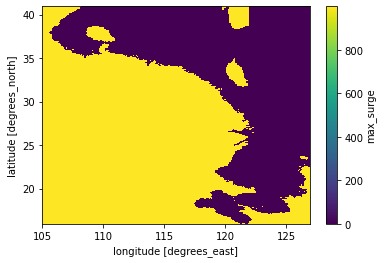

In [57]:
ds_sorted_y['max_surge'].plot()

#### step-4 根据当前规范化后的nc提取为tiff

In [17]:
ds_sorted_y=ds_sorted_y.rio.write_crs("epsg:4326", inplace=True)

In [18]:
ds_sorted_y.rio.to_raster(r'max_surge_sorted_y.tif')

In [102]:
rio_df=rioxarray.open_rasterio(r'max_surge_sorted_y.tif')

In [103]:
rio_df

<xarray.DataArray (band: 1, y: 250, x: 220)>
array([[[9.99e+02, 9.99e+02, ..., 0.00e+00, 0.00e+00],
        [9.99e+02, 9.99e+02, ..., 9.00e-04, 0.00e+00],
        ...,
        [9.99e+02, 9.99e+02, ..., 9.99e+02, 9.99e+02],
        [9.99e+02, 9.99e+02, ..., 9.99e+02, 9.99e+02]]])
Coordinates:
  * band         (band) int32 1
  * y            (y) float64 40.9 40.8 40.7 40.6 40.5 ... 16.3 16.2 16.1 16.0
  * x            (x) float64 105.0 105.1 105.2 105.3 ... 126.6 126.7 126.8 126.9
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     max_surge
    grid_mapping:  spatial_ref